## This notebook applies the fitting methods described in quasarclocks.ipynb to synthetic light curves.
Doing so allows us to check the accuracy of the fitting methods in its intended purpose.

Start by importing the required libraries.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from make_lc_plots import *#plot_lc, plot_lc_with_quad_fits, plot_lc_with_quad_slopes
from find_quadratics import find_quadratic
from scipy.optimize import curve_fit
from center_data import center_data
import numpy.polynomial.polynomial as poly
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
cm = 1/2.54
plt.style.use(['science', 'no-latex'])
plt.rc('font', size=8)
plt.rcParams['font.family'] = 'monospace'
width = 2*15.466*cm
height = width/2.55

%matplotlib inline

Next we should create some designer data. Since the finding algorithm we are using is intended to measure the slopes of the short time scale variations, the `curve_gen()` function is designed to create continuous, random fluctuations where the underlying slope of the fluctuations can be controlled

In addition we can control:
- the amount of noise in the data
- dead periods in observations
- the frequency of observations
- the variance of the slope values (i.e. a unique value or a large spread of values).

The first three options are typical issues we face in actual data so it is good to see how each of them affect our analysis.

In [2]:
def curve_gen(T=0, obs_time=3, tau=40, mu=1e-4, sigma=5e-5, dead_periods=True, cadence=15) :
    ## T   = scale of noise in data
    ## obs_time = the observation time of the quasar in years
    ## tau = the fundamental time scale of the fluctuations in days
    ## mu  = controlled slope value
    ## sigma = std of controlled slope values
    ## dead_periods = (bool; default True) dead periods in observation [False = ideal] [True = realistic]
    ## cadence = the expected cadence of the observations (i.e. frequecy of observations in days)
    
    obs_time = obs_time*365
    x = np.linspace(0, obs_time, obs_time//cadence)
    
    n_segm = obs_time//tau
    lengths = [int(tau*(1+0.1*(2*np.random.rand()-1))) for i in range(n_segm)]
    
    slopes = [np.random.choice([-1,1])*np.random.normal(mu, sigma) for i in range(n_segm)]

    xs = [np.linspace(0,lengths[i], lengths[i]) for i in range(n_segm)]
    ys = [slopes[i]*xs[i] for i in range(n_segm)]
    
    x = np.hstack([xs[i] + np.sum(lengths[:i]) if i>0 else xs[i] for i in range(n_segm)])
    y = np.hstack([ys[i] + np.sum([ys[j][-1] for j in range(i)]) if i>0 else ys[i] for i in range(n_segm)])
    noise = T*(2*np.random.rand(len(x)) - 1)
    y += noise
    
    ## apply cadence mask
    mask = [x[i]%cadence<1 for i in range(len(x))]
    x = x[mask]
    y = y[mask]
    
    if dead_periods :
        mask = [np.random.choice([True,False]) and np.random.choice([True,False]) for _ in range(len(x))]
        x = x[mask]
        y = y[mask]
    
    dy = 3e-2*np.random.exponential(scale=0.5, size=np.size(x))

    return np.vstack((x, y, dy)).T, slopes

Lets look at just one light curve for now. To start we will consider an ideal observing period (`dead_periods=False`) with a high cadence.

In [3]:
lc, slopes = curve_gen(T=2e-3, mu=1e-3, dead_periods=False, obs_time=3, cadence=5, tau=20)
lc = center_data(lc)

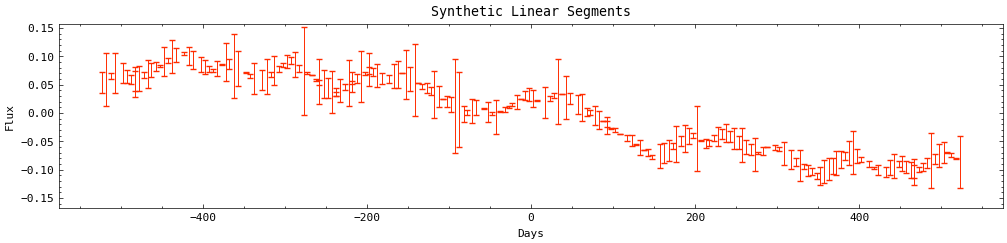

In [4]:
plot_lc(lc, title='Synthetic Linear Segments')

Now lets apply the fitting method to the light curve.

In [5]:
minww = 40
window_width, window_midpoints, fit_params, chi2dof, best_fit = find_quadratic(lc, minww)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


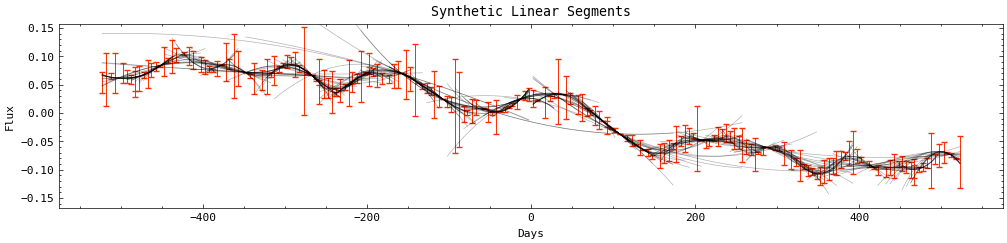

In [6]:
plot_lc_with_quad_fits(lc, best_fit, title='Synthetic Linear Segments')

In the above figure we have overlayed the quadratic fits of each segment. But what we are really interested in is the slopes that we can get from these quadratic fits. In order to relieve the affect of the turning points we take the slope at a point half way between the max and min of the quadratic fit. In the next figure we show these slopes overlaying the light curve.

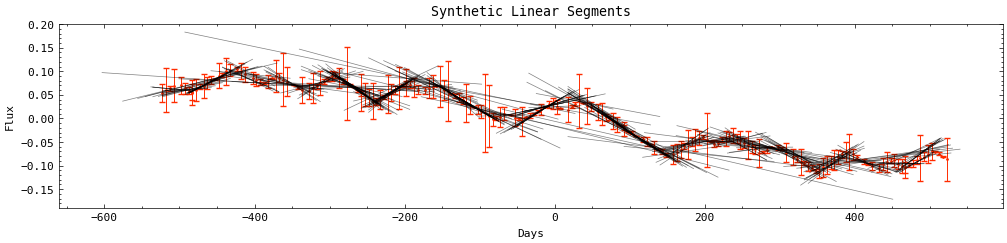

In [7]:
plot_lc_with_quad_slopes(lc, fit_params, window_midpoints, window_width, title='Synthetic Linear Segments')

If each of the quadratic functions have the form $y = \alpha x^2 + \beta x + \gamma$ then the slopes can be calculated as
$$slope = \dfrac{dy}{dx}|_{x_0} = 2\alpha x_0 + \beta$$
where $x_0$ is the $x$ value corresponding to half way between the min and max of the fit.

logsf = -3.0500383895997305^(+0.030108491974803808)_(-0.030800776563960852)


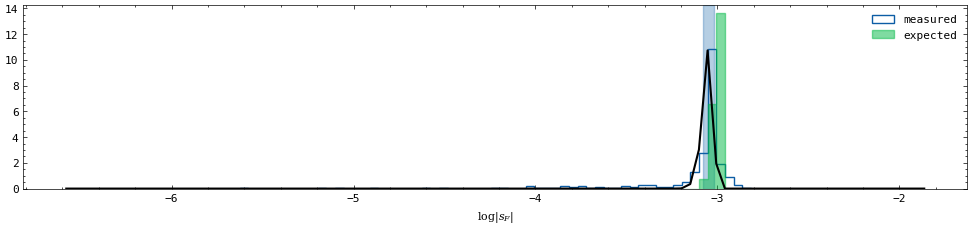

In [8]:
## make histogram of plots for one quasar
weights = 1/chi2dof
data = abs(fit_params[:,1] + 2*fit_params[:,0]*window_midpoints[:])
one_slope_histogram(data, weights, slopes)

As we can see, we do pretty well to match the expected slope value. Of course, this is with the ideal case: high cadence (5days), no observing dead periods, and low noise.

## Effect of low cadence
Now let's look at how these each of these individually affect our results. We will start with a lower cadence.

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


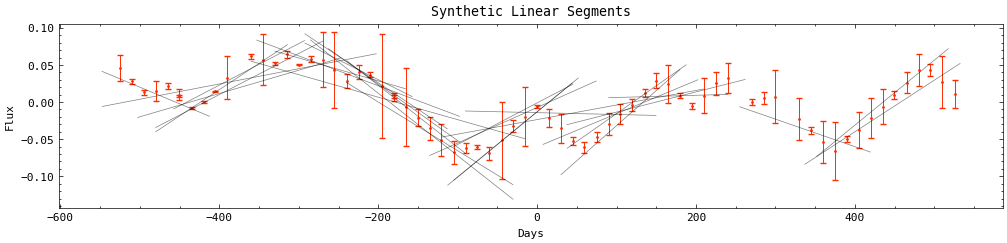

In [9]:
lc, slopes = curve_gen(T=2e-3, mu=1e-3, dead_periods=False, obs_time=3, cadence=15, tau=20)
lc = center_data(lc)

minww = 40
window_width, window_midpoints, fit_params, chi2dof, best_fit = find_quadratic(lc, minww)

plot_lc_with_quad_slopes(lc, fit_params, window_midpoints, window_width, title='Synthetic Linear Segments')

logsf = -3.0903607822019463^(+0.038242013384793605)_(-0.03898107438735776)


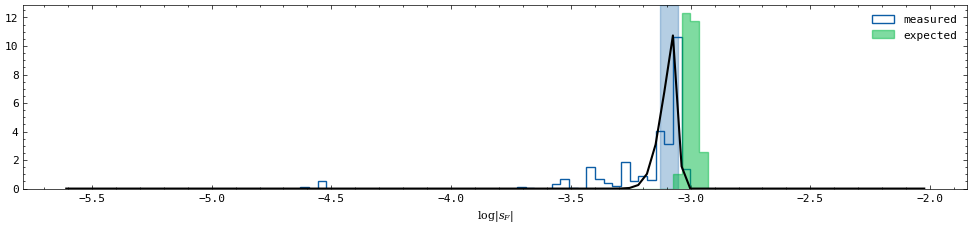

In [10]:
## make histogram of plots for one quasar
weights = 1/chi2dof
data = abs(fit_params[:,1] + 2*fit_params[:,0]*window_midpoints[:])
one_slope_histogram(data, weights, slopes)

If the cadence is much lower than the timescales of interest ($cadence/\tau \ll 1$) then the expected slope can still be determined accurately. However, as we could have guessed, as the cadence approaches higher timescales the slopes are measured as the average of multiple variations -- some of which are of opposite sign and therefore the measured slopes tend to be smaller than the expected.

## Effect of dead periods in observation
Now we see how dead periods can affect our analysis. We expect that the effect will be something similar to low cadence, but let's see.

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


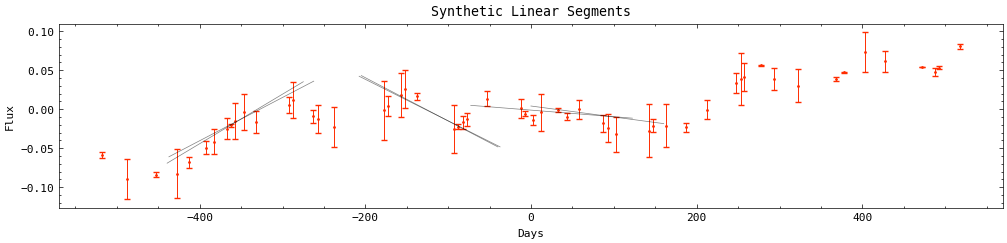

In [31]:
lc, slopes = curve_gen(T=2e-3, mu=1e-3, dead_periods=True, obs_time=3, cadence=5, tau=20)
lc = center_data(lc)

minww = 20
window_width, window_midpoints, fit_params, chi2dof, best_fit = find_quadratic(lc, minww)

plot_lc_with_quad_slopes(lc, fit_params, window_midpoints, window_width, title='Synthetic Linear Segments')

logsf = -3.2488461405770876^(+0.043005434807356746)_(-0.04384340776620643)


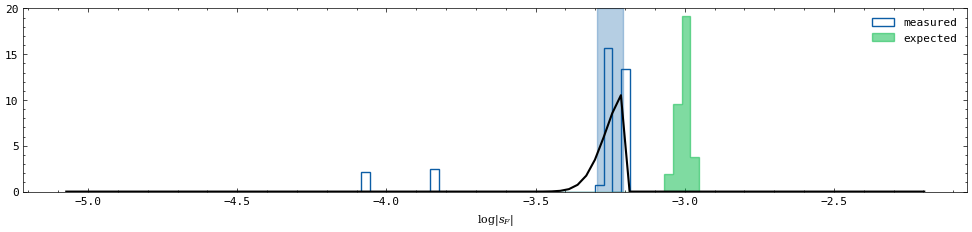

In [32]:
weights = 1/chi2dof
data = abs(fit_params[:,1] + 2*fit_params[:,0]*window_midpoints[:])
one_slope_histogram(data, weights, slopes)

As expected, dead periods cause a move towards lower slope values just like a poor cadence. But an important difference is that if the cadence is good then there still remains the ability to measure the intended slope. We can see this by improving the cadence.

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


logsf = -3.006661024273053^(+0.007788453874056689)_(-0.008061611940726632)


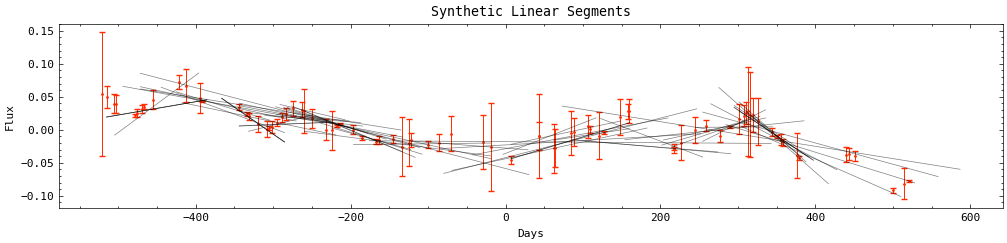

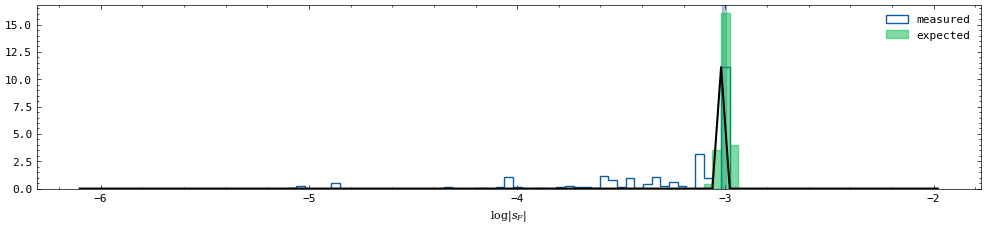

In [36]:
lc, slopes = curve_gen(T=2e-3, mu=1e-3, dead_periods=True, obs_time=3, cadence=3, tau=20)
lc = center_data(lc)

minww = 20
window_width, window_midpoints, fit_params, chi2dof, best_fit = find_quadratic(lc, minww)

plot_lc_with_quad_slopes(lc, fit_params, window_midpoints, window_width, title='Synthetic Linear Segments')

weights = 1/chi2dof
data = abs(fit_params[:,1] + 2*fit_params[:,0]*window_midpoints[:])
one_slope_histogram(data, weights, slopes)

The main issue with dead periods still remains: they significantly decrease the statistics of the slopes.

## Effect of noise
Finally, let's see how noise affects the analysis.

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


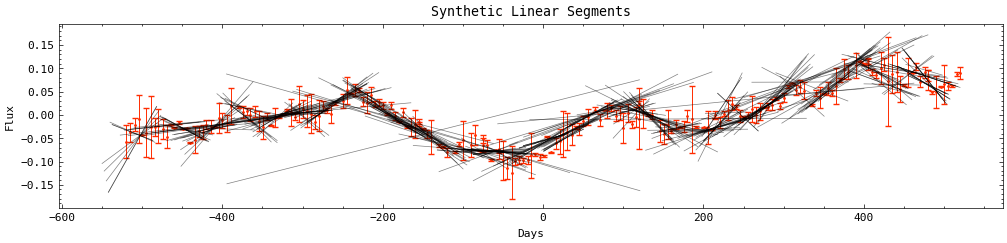

In [44]:
lc, slopes = curve_gen(T=2e-2, mu=1e-3, dead_periods=False, obs_time=3, cadence=5, tau=20)
lc = center_data(lc)

minww = 20
window_width, window_midpoints, fit_params, chi2dof, best_fit = find_quadratic(lc, minww)

plot_lc_with_quad_slopes(lc, fit_params, window_midpoints, window_width, title='Synthetic Linear Segments')

logsf = -3.04541105914602^(+0.19861386013675775)_(-0.2013524966409861)


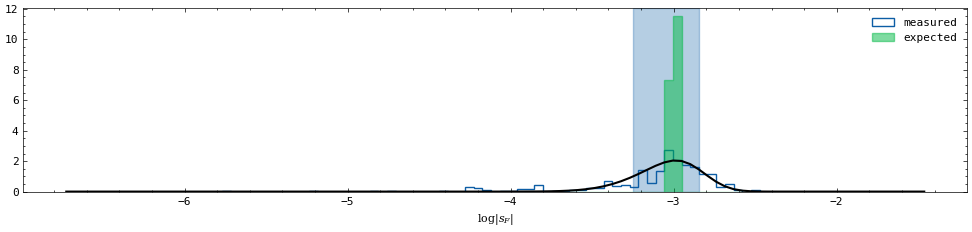

In [45]:
weights = 1/chi2dof
data = abs(fit_params[:,1] + 2*fit_params[:,0]*window_midpoints[:])
one_slope_histogram(data, weights, slopes)

Increasing noise by a factor of 10 does not seem to affect the measured value too much. Its main effect is in the widening of the distribution of measured values but the widening is symmetric.